# Decision Tree Demand Forecast

In [127]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from sklearn import tree
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import time
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

In [97]:
dailydemand = pd.read_csv('data/dailydemand.csv', index_col="time", parse_dates=True)
dailydemand = dailydemand.drop(columns=['avg_power_demand_kW', 'energy_demand_kWh', 'month'])
dailydemand

,peak_power_kW,day
time,,
2020-11-05,0.879,Thursday
2020-11-06,0.000,Friday
2020-11-07,0.000,Saturday
2020-11-08,0.000,Sunday
2020-11-09,0.000,Monday
...,...,...
2024-05-01,8.657,Wednesday
2024-05-02,17.754,Thursday
2024-05-03,11.568,Friday


To use regression trees, our dataframe must be in a format that can be used by decision trees. Each record (row) should contain all the desired features we wish to train our tree on, whereas previously, with time series analysis, past realized values were used as explanatory variables.

We can start off simple, and use the previous day's value, previous week's day's value, and a previous 7 day rolling average as features.

In [98]:
dailydemand["lag1"] = dailydemand["peak_power_kW"].shift(1)
dailydemand["lag2"] = dailydemand["peak_power_kW"].shift(2)
dailydemand["lag7"] = dailydemand["peak_power_kW"].shift(7)
dailydemand["lag14"] = dailydemand["peak_power_kW"].shift(14)
dailydemand["rollingavg7"] = dailydemand["peak_power_kW"].shift(1).rolling(7).mean()
dailydemand = dailydemand.dropna()

dailydemand = pd.concat([dailydemand, pd.get_dummies(dailydemand['day'], dtype=int)], axis=1)
dailydemand

,peak_power_kW,day,lag1,lag2,lag7,lag14,rollingavg7,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
time,,,,,,,,,,,,,,
2020-11-19,0.000,Thursday,5.893,4.980,0.000,0.879,4.069000,0,0,0,0,1,0,0
2020-11-20,0.000,Friday,0.000,5.893,0.736,0.000,4.069000,1,0,0,0,0,0,0
2020-11-21,0.000,Saturday,0.000,0.000,6.494,0.000,3.963857,0,0,1,0,0,0,0
2020-11-22,0.000,Sunday,0.000,0.000,6.494,0.000,3.036143,0,0,0,1,0,0,0
2020-11-23,0.000,Monday,0.000,0.000,3.886,0.000,2.108429,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-01,8.657,Wednesday,22.012,12.788,26.090,12.287,18.870143,0,0,0,0,0,0,1
2024-05-02,17.754,Thursday,8.657,22.012,32.287,18.660,16.379714,0,0,0,0,1,0,0
2024-05-03,11.568,Friday,17.754,8.657,26.659,12.503,14.303571,1,0,0,0,0,0,0


## Vanilla Regression Trees

As a baseline, let's heuristically set out maximum tree depth to 7, maximum leaf nodes to 16, minimum samples in a leaf node to 5, and minimum samples to split to 20 and fit our model. 

Note that values are being forecasted one time step at a time, as at each time step, the model is given the **true** `lag1`, `lag2`, `lag7`, and `rollingavg7` values.

### Train & Test Split

Let's split our data while maintaining its temporality; we can take the first 80% of values to train and the last 20% to test.

In [109]:
# Split our data into training and test splits
test_size = 0.8
train = dailydemand[:int(test_size * len(dailydemand)):]
test = dailydemand[int(test_size * len(dailydemand))::]

# Create X & y training and test data
X_train = train.drop(columns = ["peak_power_kW", "day"])
X_test = test.drop(columns = ["peak_power_kW", "day"])
Y_train = train["peak_power_kW"]
Y_test = test["peak_power_kW"]

Train Set RMSE: 6.6486532762449055 kW
Test Set RMSE: 8.224666279159631 kW


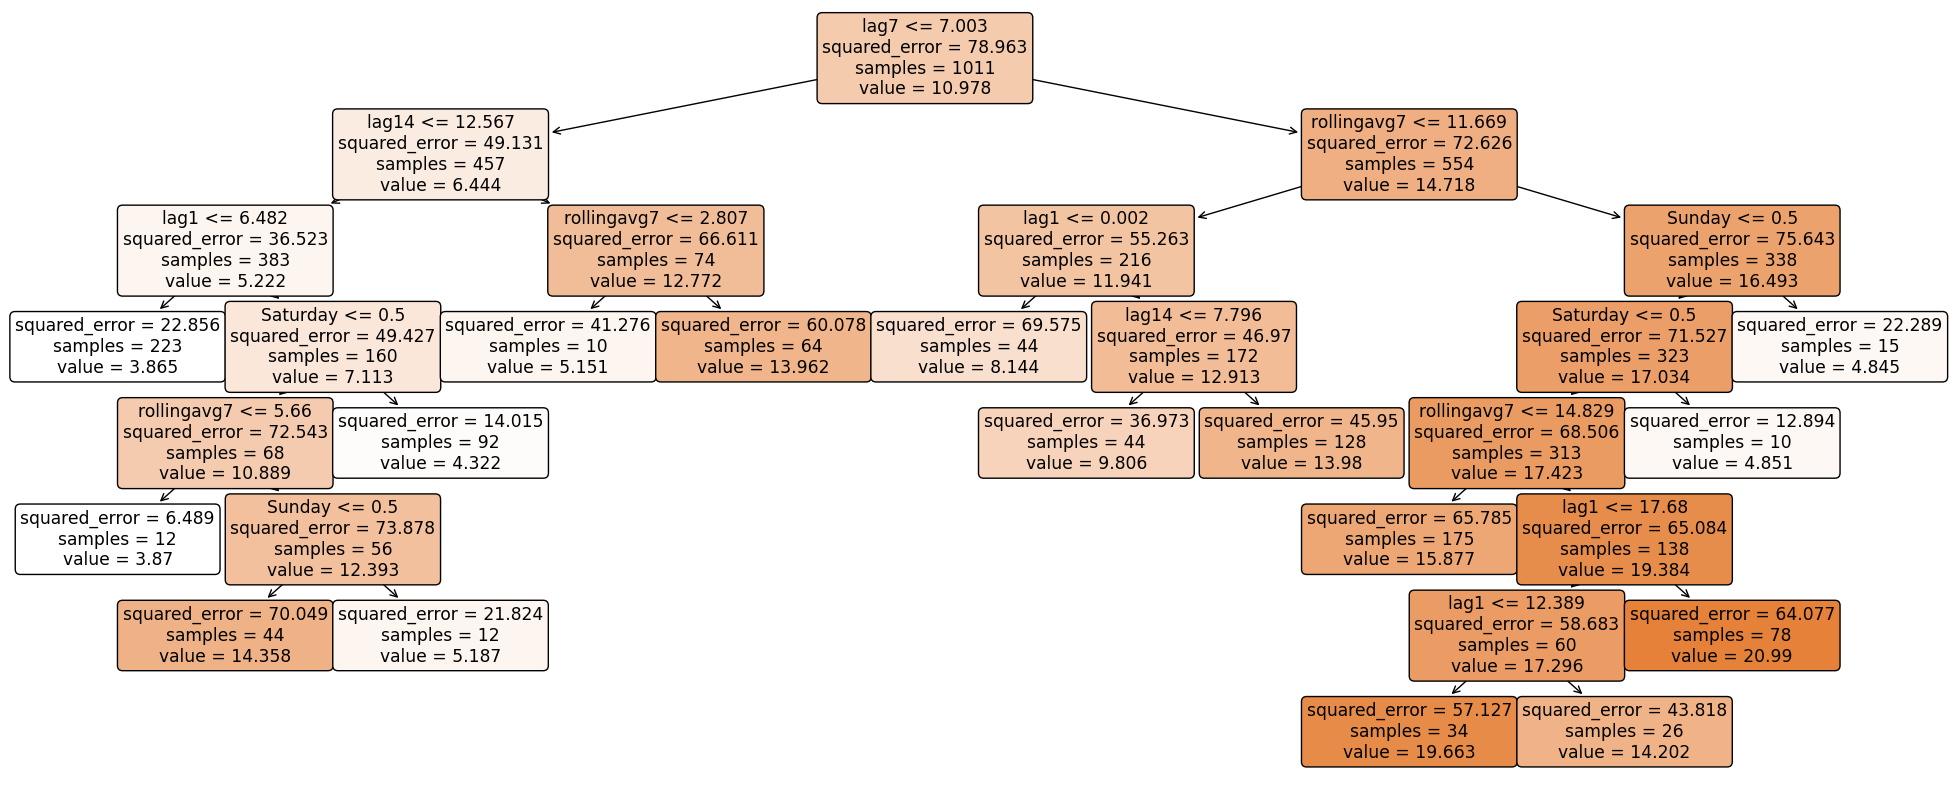

In [57]:
# Create regressor object
regressor = DecisionTreeRegressor(max_leaf_nodes=16, max_depth=7, min_samples_leaf=5, min_samples_split=20)

# Fit and predict model
regressor.fit(X_train, Y_train)
dtree_test_predictions = regressor.predict(X_test)

# Visualization
fig = go.Figure()
fig.add_trace(
    go.Scatter(x = dailydemand.index , y = dailydemand["peak_power_kW"], name = "True Data", hovertext=dailydemand["day"])
)
fig.add_trace(
    go.Scatter(x = X_train.index, y = regressor.predict(X_train) , name = "In-Sample Regression Tree Forecast" , line= {"color":"#FF8C00"},hovertext=dailydemand["day"])
)
fig.add_trace(
    go.Scatter(x = X_test.index,
               y = dtree_test_predictions, name = "Out-of-Sample Regression Tree Forecast" , line= {"color":"Red"}, hovertext=dailydemand["day"].loc[dailydemand.index >= test.index[0]])
)
fig.update_layout({"title" : f"Regression Tree Forecast<br>Max Depth = {regressor.max_depth}" , "yaxis_title" : "Peak Daily Power (kW)"})
fig.show()
print(f'Train Set RMSE: {root_mean_squared_error(Y_train, regressor.predict(X_train))} kW')
print(f'Test Set RMSE: {root_mean_squared_error(Y_test, dtree_test_predictions)} kW')

fig = plt.figure(figsize = (25,10))
tree.plot_tree(regressor, feature_names=X_train.columns, filled=True, rounded=True)
plt.show()


### Pruning Regression Trees
Above, we manually selected the tree depth to avoid overfitting; alternatively, we allow the tree to grow to large, then remove splits that don't improve the performance of the model.

This usually works better than limiting tree growth because splits that don't make progress are often followed by splits that make a lot of progress. Stunting tree depth beforehand can make it impossible to find these effective, later splits.
We can "regularize" the tree according to the follow cost function:

$\sum\limits_{m=1}^{|T|} \sum\limits_{i: x_i\in R_M} (y_i - \hat{y}_{R_{m}})^{2} + \alpha|T|$

Here, $|T|$ represents the number of leaves in the tree, $R_m$ is the subset of the predictor space corresponding to the *m*th leaf, and $\hat{y}_{R_{m}}$ is the prediction associated with $R_m$. The term $\alpha$ can be thought of the regularizing parameter that punishes big trees; if there are many leaves (a full grown tree), the error term increases. A value of $\alpha = 0$ inflicts no punishment as a function of the number of leaves (tree complexity is not punished).
Below, we see that as we increase the regularizing parameter $\alpha$, the impurity of the leaves go up. A low $\alpha$ corresponds to a fully grown tree with no restrictions, and thus leaves are very pure.

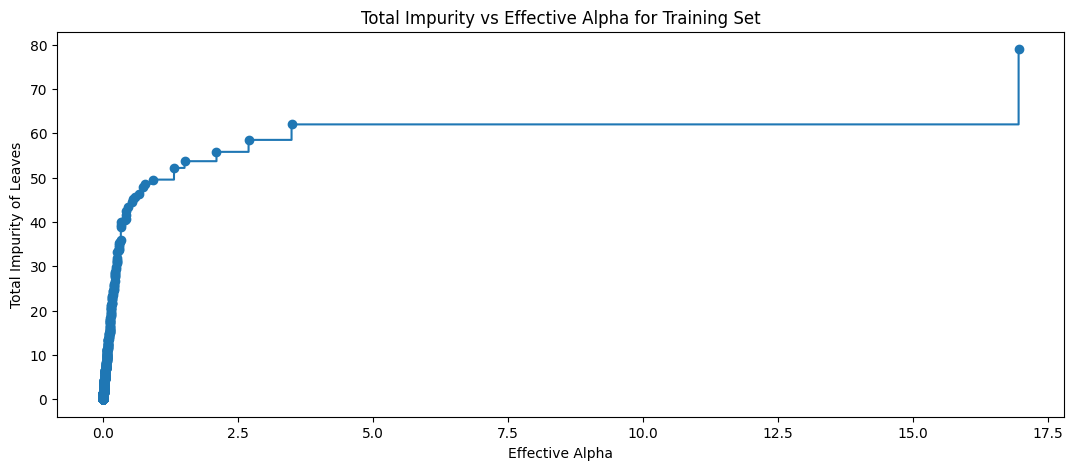

In [74]:
clf = DecisionTreeRegressor(random_state=0)
path = clf.cost_complexity_pruning_path(X_train, Y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

plt.figure(figsize=(13,5))
plt.plot(ccp_alphas, impurities, marker="o", drawstyle="steps-post")
plt.xlabel("Effective Alpha")
plt.ylabel("Total Impurity of Leaves")
plt.title("Total Impurity vs Effective Alpha for Training Set")
plt.show()

#### Cross Validation for $\alpha$

In [73]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeRegressor(ccp_alpha=ccp_alpha)
    clf.fit(X_train, Y_train)
    clfs.append(clf)
print(f"Number of nodes in the first tree is: {clfs[0].tree_.node_count} with ccp_alpha: {ccp_alphas[0]}"
    f"\nNumber of nodes in the last tree is: {clfs[-1].tree_.node_count} with ccp_alpha: {ccp_alphas[-1]}")

Number of nodes in the first tree is: 1821 with ccp_alpha: 0.0
Number of nodes in the last tree is: 1 with ccp_alpha: 16.958043302515996


We can perform a time-series split cross validation in order to find an optimal $\alpha$ value. At each fold, we train a model and evaluate its performance on the validation set. We do this for every value of $\alpha$.

In the figure below, the blue represents the training set and the red represents the validation set.

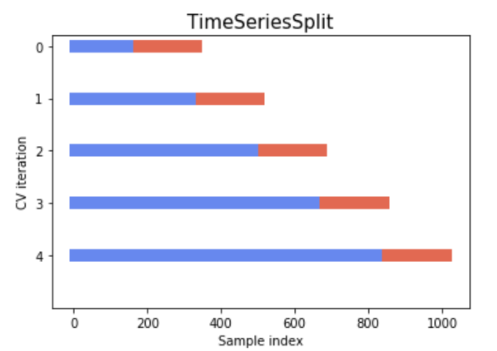

Best Alpha: 1.3200419334796694


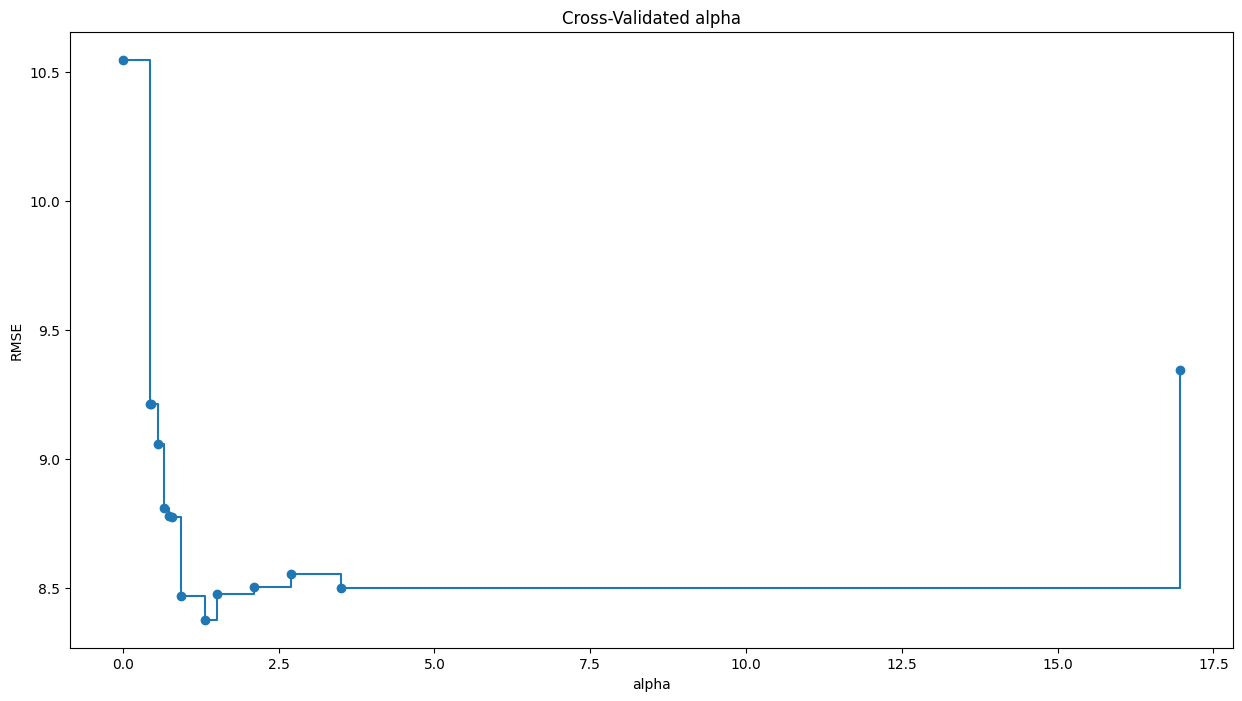

In [72]:
tscv = TimeSeriesSplit()

all_tree_models = {}

# loop through every value of alpha
for ccp_alpha in ccp_alphas:
    
    # create model
    current_model = DecisionTreeRegressor(ccp_alpha=ccp_alpha)
    cv_error = []
    
    # perform cross validation
    for train_index, test_index in tscv.split(X_train):
        X_train_cv, X_test_cv = X_train.iloc[train_index], X_train.iloc[test_index]
        Y_train_cv, Y_test_cv = Y_train.iloc[train_index], Y_train.iloc[test_index]
        
        # fit model to the training data
        current_model.fit(X_train_cv, Y_train_cv)
        # evaluate model on validation set
        cv_error.append(root_mean_squared_error(Y_test_cv, current_model.predict(X_test_cv)))
    
    # store final error and alpha value 
    all_tree_models[np.mean(cv_error)] = ccp_alpha

best_alpha = all_tree_models.get(min(all_tree_models))
print(f"Best Alpha: {best_alpha}")

plt.figure(figsize=(15,8))
plt.plot(all_tree_models.values(), all_tree_models.keys(), marker='o', drawstyle="steps-post")
plt.xlabel("alpha")
plt.ylabel("RMSE")
plt.title("Cross-Validated alpha")
plt.show()

#### Best Regularized Tree Model

Here we used our found $\alpha$ value to create a regression tree.

In [71]:
# Create regressor object
reg_regressor = DecisionTreeRegressor(ccp_alpha=best_alpha)

# Fit and predict model
reg_regressor.fit(X_train, Y_train)

dtree_test_predictions = reg_regressor.predict(X_test)

fig = go.Figure()
fig.add_trace(
    go.Scatter(x = dailydemand.index , y = dailydemand["peak_power_kW"], name = "True Data", hovertext=dailydemand["day"])
)
fig.add_trace(
    go.Scatter(x = X_train.index, y = reg_regressor.predict(X_train) , name = "In-Sample Regression Tree Forecast" , line= {"color":"#FF8C00"},hovertext=dailydemand["day"])
)
fig.add_trace(
    go.Scatter(x = X_test.index,
               y = dtree_test_predictions, name = "Out-of-Sample Regression Tree Forecast" , line= {"color":"Red"}, hovertext=dailydemand["day"].loc[dailydemand.index >= test.index[0]])
)
fig.update_layout({"title" : f"Regression Tree Forecast<br>Depth = {reg_regressor.get_depth()}" , "yaxis_title" : "Peak Daily Power (kW)"})
fig.show()
print(f'Train Set RMSE: {root_mean_squared_error(Y_train, reg_regressor.predict(X_train))} kW')
print(f'Test Set RMSE: {root_mean_squared_error(Y_test, dtree_test_predictions)} kW')

Train Set RMSE: 7.038893486341181 kW
Test Set RMSE: 8.27814820751245 kW


### Parameter Grid Search

We can also iterate through various parameters of a decision tree regressor, such as the maximum allowed number of leaf nodes, the maximum depth, minimum samples per leaf, and minimum number of samples to split a node. We can use the optimal parameter to create a decision tree regressor.

In [84]:
pipeline = Pipeline([("estimator", DecisionTreeRegressor())])

max_leaf_nodes=16
max_depth=7
min_samples_leaf=5
min_samples_split=20

params = {
    "estimator__max_leaf_nodes": np.arange(2,max_leaf_nodes+1), 
    "estimator__max_depth": np.arange(1,max_depth+1),
    "estimator__min_samples_leaf": np.arange(1,min_samples_leaf+1),
    "estimator__min_samples_split": np.arange(2,min_samples_split+1),
    }

grid = GridSearchCV(estimator=pipeline, 
                    param_grid=params, 
                    scoring="neg_mean_squared_error", 
                    n_jobs=8, 
                    verbose=4,
                    cv=TimeSeriesSplit(),
                   )

start = time.time()
grid.fit(X_train, Y_train)
end = time.time()
print(f"Total Fit Time: {end-start} s")

Fitting 5 folds for each of 9975 candidates, totalling 49875 fits
Total Fit Time: 39.03096008300781 s


Train Set RMSE: 6.649731558935228 kW
Test Set RMSE: 8.194757954172443 kW


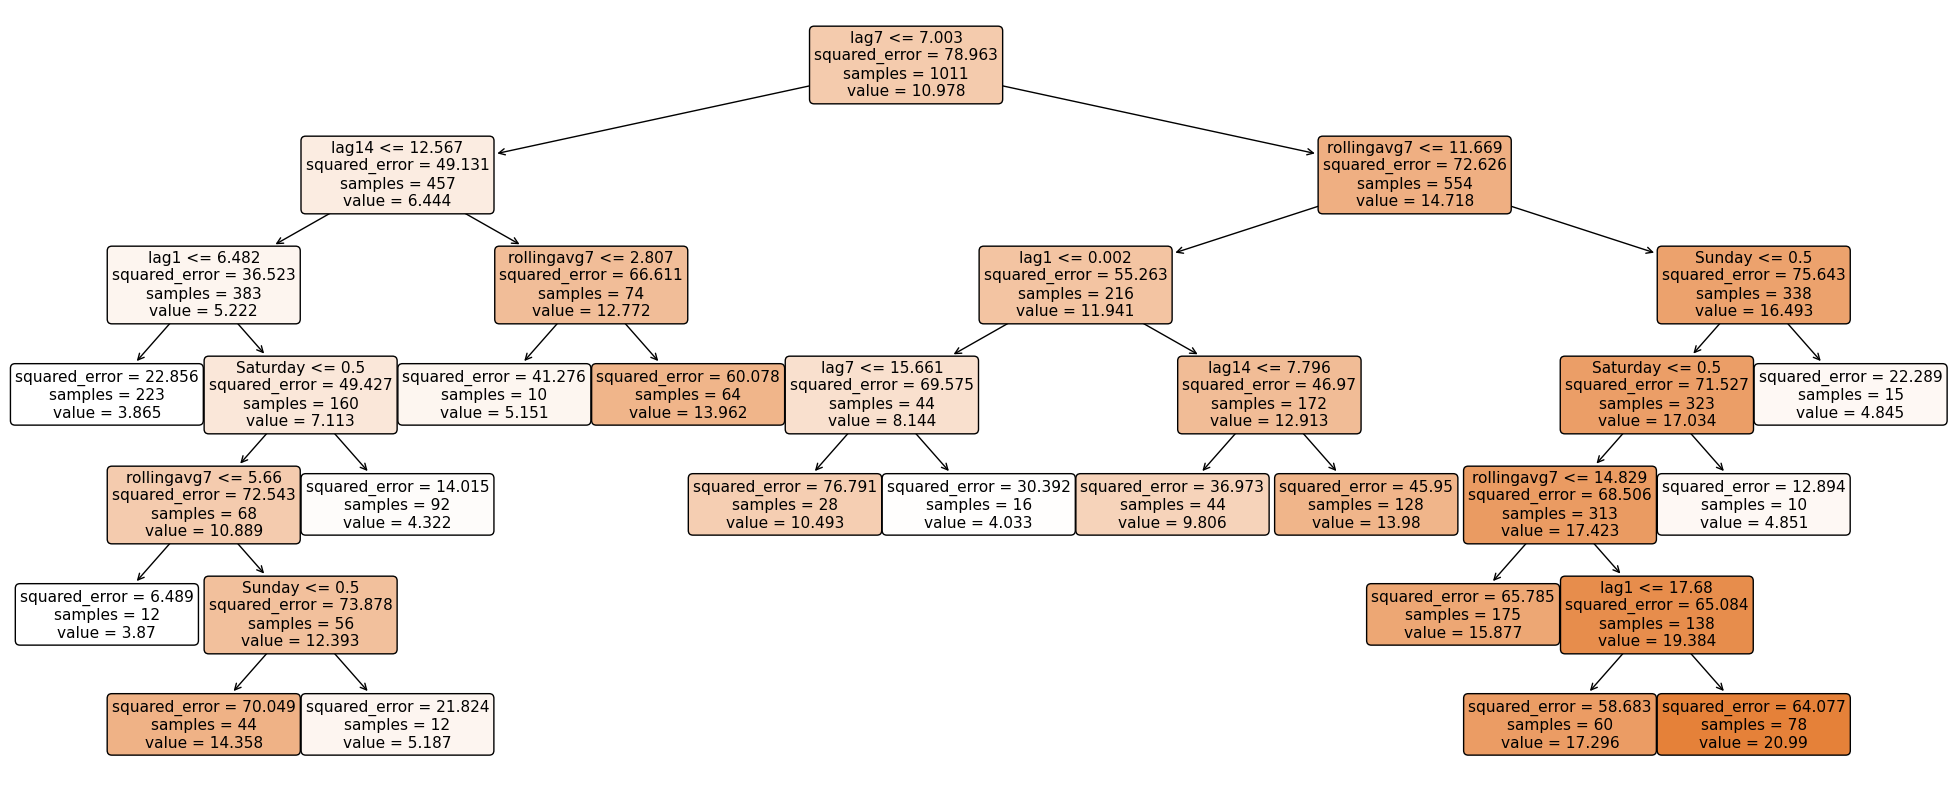

In [89]:
# Create regressor object
reg_regressor = DecisionTreeRegressor(
    max_depth=grid.best_params_["estimator__max_depth"], 
    max_leaf_nodes=grid.best_params_["estimator__max_leaf_nodes"], 
    min_samples_leaf=grid.best_params_["estimator__min_samples_leaf"], 
    min_samples_split=grid.best_params_["estimator__min_samples_split"]
)

# Fit and predict model
reg_regressor.fit(X_train, Y_train)

dtree_test_predictions = reg_regressor.predict(X_test)

fig = go.Figure()
fig.add_trace(
    go.Scatter(x = dailydemand.index , y = dailydemand["peak_power_kW"], name = "True Data", hovertext=dailydemand["day"])
)
fig.add_trace(
    go.Scatter(x = X_train.index, y = reg_regressor.predict(X_train) , name = "In-Sample Regression Tree Forecast" , line= {"color":"#FF8C00"},hovertext=dailydemand["day"])
)
fig.add_trace(
    go.Scatter(x = X_test.index,
               y = dtree_test_predictions, name = "Out-of-Sample Regression Tree Forecast" , line= {"color":"Red"}, hovertext=dailydemand["day"].loc[dailydemand.index >= test.index[0]])
)
fig.update_layout({"title" : f"Regression Tree Forecast<br>Depth = {reg_regressor.get_depth()}" , "yaxis_title" : "Peak Daily Power (kW)"})
fig.show()
print(f'Train Set RMSE: {root_mean_squared_error(Y_train, reg_regressor.predict(X_train))} kW')
print(f'Test Set RMSE: {root_mean_squared_error(Y_test, dtree_test_predictions)} kW')

fig = plt.figure(figsize = (25,10))
tree.plot_tree(reg_regressor, feature_names=X_train.columns, filled=True, rounded=True)
plt.show()

## Random Forests

In order to use random forests, we need to encode lags into our data.

In [128]:
dailydemand_rf = pd.read_csv("data/dailydemand.csv", index_col="time", parse_dates=True)
dailydemand_rf = dailydemand_rf.drop(columns=['avg_power_demand_kW', 'energy_demand_kWh', 'month'])
dailydemand_rf

,peak_power_kW,day
time,,
2020-11-05,0.879,Thursday
2020-11-06,0.000,Friday
2020-11-07,0.000,Saturday
2020-11-08,0.000,Sunday
2020-11-09,0.000,Monday
...,...,...
2024-05-01,8.657,Wednesday
2024-05-02,17.754,Thursday
2024-05-03,11.568,Friday


In [129]:
max_lags = 35

for i in range(1, max_lags+1):
    dailydemand_rf[f"lag{i}"] = dailydemand_rf["peak_power_kW"].shift(i)

for i in [3, 5, 7, 10, 14]:
    dailydemand_rf[f"rollingavg{i}"] = dailydemand_rf["peak_power_kW"].shift(1).rolling(i).mean()

dailydemand_rf = dailydemand_rf.dropna()

dailydemand_rf = pd.concat([dailydemand_rf, pd.get_dummies(dailydemand_rf['day'], dtype=int)], axis=1)
dailydemand_rf

,peak_power_kW,day,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,...,rollingavg7,rollingavg10,rollingavg14,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
time,,,,,,,,,,,,,,,,,,,,,
2020-12-10,0.000,Thursday,0.000,5.794,6.669,0.000,0.000,1.469,0.000,13.165,...,1.990286,3.1183,2.227357,0,0,0,0,1,0,0
2020-12-11,0.000,Friday,0.000,0.000,5.794,6.669,0.000,0.000,1.469,0.000,...,1.990286,3.1183,2.227357,1,0,0,0,0,0,0
2020-12-12,0.000,Saturday,0.000,0.000,0.000,5.794,6.669,0.000,0.000,1.469,...,1.780429,2.7097,2.227357,0,0,1,0,0,0,0
2020-12-13,0.000,Sunday,0.000,0.000,0.000,0.000,5.794,6.669,0.000,0.000,...,1.780429,1.3932,2.227357,0,0,0,1,0,0,0
2020-12-14,0.000,Monday,0.000,0.000,0.000,0.000,0.000,5.794,6.669,0.000,...,1.780429,1.3932,2.227357,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-01,8.657,Wednesday,22.012,12.788,6.161,6.094,26.659,32.287,26.090,29.280,...,18.870143,18.8478,16.566286,0,0,0,0,0,0,1
2024-05-02,17.754,Thursday,8.657,22.012,12.788,6.161,6.094,26.659,32.287,26.090,...,16.379714,18.4628,16.307000,0,0,0,0,1,0,0
2024-05-03,11.568,Friday,17.754,8.657,22.012,12.788,6.161,6.094,26.659,32.287,...,14.303571,18.7782,16.242286,1,0,0,0,0,0,0


### Train & Test Split

Let's split our data while maintaining its temporality; we can take the first 80% of values to train and the last 20% to test.

In [117]:
# Split our data into training and test splits
test_size = 0.8
train = dailydemand_rf[:int(test_size * len(dailydemand_rf)):]
test = dailydemand_rf[int(test_size * len(dailydemand_rf))::]

# Create X & y training and test data
X_train = train.drop(columns = ["peak_power_kW", "day"])
X_test = test.drop(columns = ["peak_power_kW", "day"])
Y_train = train["peak_power_kW"]
Y_test = test["peak_power_kW"]

In [151]:
rf = RandomForestRegressor(n_estimators=1000, random_state=0, n_jobs=4)
rf.fit(X_train, Y_train)

fig = go.Figure()
fig.add_trace(
    go.Scatter(x = dailydemand_rf.index , y = dailydemand_rf["peak_power_kW"], name = "True Data", hovertext=dailydemand_rf["day"])
)
fig.add_trace(
    go.Scatter(x = X_train.index, y = rf.predict(X_train) , name = "In-Sample Random Forest Forecast" , line= {"color":"#FF8C00"}, hovertext=dailydemand["day"])
)
fig.add_trace(
    go.Scatter(x = X_test.index,
               y = rf.predict(X_test), name = "Out-of-Sample Random Forest Forecast" , line= {"color":"Red"}, hovertext=dailydemand_rf["day"].loc[dailydemand_rf.index >= test.index[0]])
)
fig.update_layout({"title" : f"Regression Tree Forecast" , "yaxis_title" : "Peak Daily Power (kW)"})
fig.show()

print(f'Train Set RMSE: {root_mean_squared_error(Y_train, rf.predict(X_train))} kW')
print(f'Test Set RMSE: {root_mean_squared_error(Y_test, rf.predict(X_test))} kW')

Train Set RMSE: 2.5461172946527437 kW
Test Set RMSE: 8.17874164906991 kW


## Future

Random forests, XGBoost, more complex tree models. 
Could we try a random forest method on highly dimensional (many lags) data? Randoms forests take a subset of the features during bagging.